In [14]:
import pandas as pd 

#Import coral data (already transformed)
coral_filepath = '/cluster/home/maikents/midnor_total_coral_data_processed.parquet'
coral_data = pd.read_parquet(coral_filepath)
coral_x = coral_data['x']
coral_y = coral_data['y']

print(coral_data.columns)

Index(['gml_id', 'lokalId', 'navnerom', 'verifiseringsdato', 'produkt',
       'versjon', 'målemetode', 'nøyaktighet', 'medium', 'opphav',
       'minimumsdybde', 'maksimumsdybde', 'naturtype', 'naturtypeNavn',
       'kildeNavn', 'observasjonsMetode', 'observasjonsSted',
       'observasjonsSlutt', 'lengdegrad', 'breddegrad', 'geometry', 'x', 'y'],
      dtype='object')


In [15]:
#Import SINMOD data 
import xarray as xr
from netCDF4 import Dataset
# Load the 4D SINMOD dataset
#ds = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")

#Load the 2D midnor SINMOD dataset to get "gridLons" variable
#ds_2d = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc")
#gridLons = ds_2d["gridLons"]

#Add gridLons to ds
#ds['gridLons'] = gridLons

#t_range = 0, len(ds['time'])

#Explore variables in sinmod dataset
#print(ds.data_vars.keys())


filename_PhysStates = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'
filename_physstates_2d = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

midnor_PhysStates_data = Dataset(filename_PhysStates, 'r')
physstates_2d = Dataset(filename_physstates_2d, 'r')

gridLons = physstates_2d.variables['gridLons']

Statistics for coral values: {'mean': np.float64(0.11455125494230722), 'max': np.float64(0.9999999994680161), 'min': np.float64(-0.9999999987711149), '90th_percentile': np.float64(0.9132954646032476), '10th_percentile': np.float64(-0.7969905422331511)}


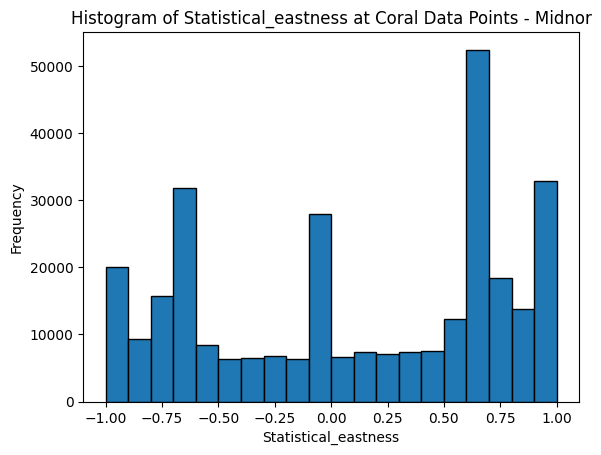

Number of valid coordinates: 836 out of 941


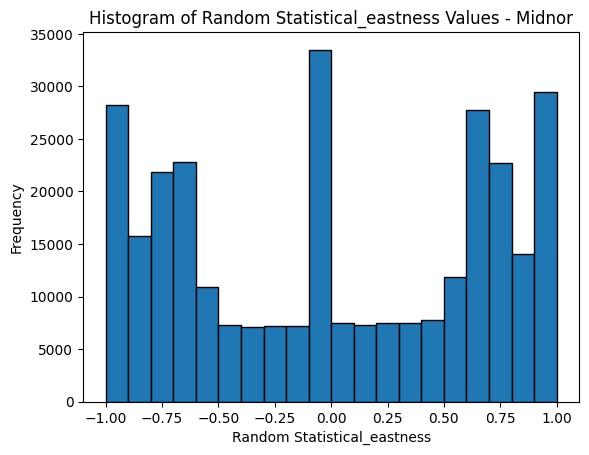

Statistics for random values: {'mean': np.float64(0.01506766118374357), 'max': np.float64(0.9999999999920424), 'min': np.float64(-0.9999999999329071), '90th_percentile': np.float64(0.8928425507505622), '10th_percentile': np.float64(-0.8833571679908863)}


In [16]:
# Now plot histogram of temperature values at coral data points
import random
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram_at_coral_points(netcdf_data, gridLons, coral_data, variable_name, t_range, generate_random=False, save=False, save_path="midnor"):

    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')


    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    if t_stop == -1:
        t_stop = netcdf_data.variables['time'].shape[0]

    # Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):
        
        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            # Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                elif variable_name == 'statistical_northness' or variable_name == 'statistical_eastness':
                    longitude_at_point = gridLons[int(y), int(x)]
                    theta = longitude_at_point - longitude_of_projection_origin
                    eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                    northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                    aspect = np.arctan2(eastward_velocity, northward_velocity)
                    if variable_name == 'statistical_eastness':
                        value = np.sin(aspect)
                    else:
                        value = np.cos(aspect)
                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    if (x, y) not in valid_coordinates:
                        valid_coordinates.append((x, y))

    # Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    # Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    # Calculate statistics for coral values
    stats = {
        'mean': np.mean(coral_values_flat),
        'max': np.max(coral_values_flat),
        'min': np.min(coral_values_flat),
        '90th_percentile': np.percentile(coral_values_flat, 90),
        '10th_percentile': np.percentile(coral_values_flat, 10)
    }

    print(f"Statistics for coral values: {stats}")

    # Determine the bin edges for the histograms
    bin_edges = np.histogram_bin_edges(coral_values_flat, bins=20)

    # Plot histogram of the combined variable values
    plt.hist(coral_values_flat, bins=bin_edges, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points - {save_path.capitalize()}')
    
    if save:
        plt.savefig(f'plots/variable_histograms/{variable_name}_histogram_coral_points_{save_path}.png')
    
    plt.show()

    print(f"Number of valid coordinates: {len(valid_coordinates)} out of {len(coral_data)}")

    if generate_random:
        # Plotting random histogram

        no_points = int(len(valid_coordinates))

        # Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        random_values = []

        for time in range(t_start, t_stop):

            selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

            for y, x in selected_indices:
                
                # Ensure the coordinates are within the grid bounds
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)
                    elif variable_name == 'statistical_northness' or variable_name == 'statistical_eastness':
                        longitude_at_point = gridLons[int(y), int(x)]
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                        if variable_name == 'statistical_eastness':
                            value = np.sin(aspect)
                        else:
                            value = np.cos(aspect)
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
        
        # Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        # Flatten the array to combine all time steps
        random_values_flat = random_values.flatten()

        # Plot histogram of the combined random variable values
        plt.hist(random_values_flat, bins=bin_edges, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}')
        plt.ylabel('Frequency')
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values - {save_path.capitalize()}')
        
        if save:
            plt.savefig(f'plots/variable_histograms/{variable_name}_histogram_coral_points_{save_path}_random.png')
        
        plt.show()

        random_stats = {
            'mean': np.mean(random_values_flat),
            'max': np.max(random_values_flat),
            'min': np.min(random_values_flat),
            '90th_percentile': np.percentile(random_values_flat, 90),
            '10th_percentile': np.percentile(random_values_flat, 10)
        }

        print(f"Statistics for random values: {random_stats}")

        return coral_values, stats, random_values, random_stats
    return coral_values, stats

# Example usage
t_range = (0, len(midnor_PhysStates_data.variables['time']))
# plot_histogram_at_coral_points(PhysStates_data, coral_data, 'temperature', (0, 50))
# plot_histogram_at_coral_points(nor4km_PhysStates_data, nor4km_coral_data, 'temperature', (0, 50))
midnor_stat_east, midnor_stats_stat_east, midnor_stat_east_random, midnor_stat_east_random_stats = plot_histogram_at_coral_points(midnor_PhysStates_data, gridLons,coral_data, 'statistical_eastness', t_range, True)
# plot_histogram_at_coral_points(midnor_PhysStates_data, midnor_coral_data, 'salinity', (0, 50))

/tmp/ipykernel_2766531/3408854295.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


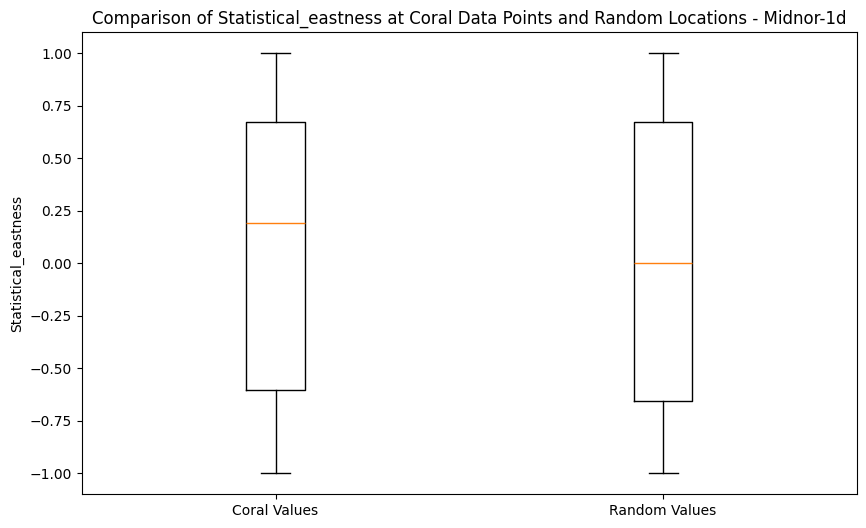

In [17]:
import os

def plot_comparison_boxplots(coral_values, random_values, variable_name, save=False, save_path="midnor"):
    """
    Plots box and whisker plots comparing coral values to random values.

    Parameters:
    coral_values (numpy.ndarray): Array of values at coral data points.
    random_values (numpy.ndarray): Array of random values.
    variable_name (str): Name of the variable being plotted.
    save (bool): Whether to save the plot as a file.
    save_path (str): Path to save the plot file.
    """
    data = [coral_values, random_values]
    labels = ['Coral Values', 'Random Values']

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.ylabel(variable_name.capitalize())
    plt.title(f'Comparison of {variable_name.capitalize()} at Coral Data Points and Random Locations - {save_path.capitalize()}')
    
    if save:
        if not os.path.exists('plots/boxplots'):
            os.makedirs('plots/boxplots')
        plt.savefig(f'plots/boxplots/{variable_name}_comparison_boxplot_{save_path}.png')
    
    plt.show()

# Plot temperature comparison
plot_comparison_boxplots(midnor_stat_east, midnor_stat_east_random, 'statistical_eastness', save=False, save_path="midnor-1d")
